In [1]:
import rdkit
from rdkit import Chem
from rdkit.Chem import AllChem
import subprocess
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [5]:
!pip install requests

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4/4 [requests]1/4 [idna]


In [13]:
import requests
import pandas as pd
import os

# 1. Define and Create the path
output_dir = "/home/nikki/egfr_lowdata_scoring/data/ligands_real"
os.makedirs(output_dir, exist_ok=True)  # This creates the folder if it doesn't exist

# 2. API URL
url = "https://www.ebi.ac.uk/chembl/api/data/activity?target_chembl_id=CHEMBL203&limit=1000&format=json"

# 3. Send request
r = requests.get(url)
if r.status_code != 200:
    raise Exception(f"Failed to fetch data: {r.status_code}")

# 4. Convert JSON to pandas DataFrame
data = r.json()
df = pd.json_normalize(data['activities'])

# 5. Save as CSV
output_file = os.path.join(output_dir, "EGFR_activities.csv")
df.to_csv(output_file, index=False)


In [15]:
import pandas as pd
import os

# Paths
csv_file = "EGFR_all_activities.csv"
out_smi = "/home/nikki/egfr_lowdata_scoring/data/ligands_real/egfr_real.smi"

os.makedirs("/home/nikki/egfr_lowdata_scoring/data/ligands_real/", exist_ok=True)

# Load CSV
df = pd.read_csv("/home/nikki/egfr_lowdata_scoring/data/ligands_real/EGFR_activities.csv")

# Keep only needed columns
df = df[[
    "molecule_chembl_id",
    "canonical_smiles",
    "standard_value",
    "standard_units"
]]

# Drop missing values
df = df.dropna(subset=["canonical_smiles", "standard_value"])

# OPTIONAL: keep only IC50 in nM
df = df[
    (df["standard_units"] == "nM")
]

# OPTIONAL: define activity threshold
# Active if IC50 <= 100 nM
df["label"] = (df["standard_value"] <= 100).astype(int)

# OPTIONAL: select ~50 ligands (balanced if possible)
df = df.drop_duplicates("molecule_chembl_id")
df = df.sample(n=min(50, len(df)), random_state=42)

# Write .smi file
with open(out_smi, "w") as f:
    for _, row in df.iterrows():
        f.write(f"{row['canonical_smiles']} {row['molecule_chembl_id']}\n")

print(f"Saved {len(df)} ligands to {out_smi}")


Saved 50 ligands to /home/nikki/egfr_lowdata_scoring/data/ligands_real/egfr_real.smi


In [17]:
from rdkit import Chem
from rdkit.Chem import AllChem
import os

smiles_file = "/home/nikki/egfr_lowdata_scoring/data/ligands_real/egfr_real.smi"
out_folder = "/home/nikki/egfr_lowdata_scoring/data/ligands_real/prepared_3D/"
os.makedirs(out_folder, exist_ok=True)

with open(smiles_file, 'r') as f:
    lines = f.readlines()

for line in lines:
    parts = line.strip().split()  # split by whitespace
    if len(parts) < 2:
        continue  # skip bad lines

    smi = parts[0]          # SMILES
    ligand_id = parts[1]    # CHEMBL ID

    mol = Chem.MolFromSmiles(smi)
    if mol is None:
        print(f"Failed to parse: {smi}")
        continue

    mol = Chem.AddHs(mol)  # add hydrogens

    # Embed 3D conformer
    AllChem.EmbedMolecule(mol, randomSeed=42)
    AllChem.UFFOptimizeMolecule(mol)  # energy minimization

    # Save as SDF
    writer = Chem.SDWriter(os.path.join(out_folder, f"{ligand_id}.sdf"))
    writer.write(mol)
    writer.close()

print("All ligands processed!")


All ligands processed!


In [1]:
#Extract erlotinib coordinates

import numpy as np

pdb_file = "/home/nikki/egfr_lowdata_scoring/data/protein/1M17.pdb"

ligand_coords = []

with open(pdb_file, "r") as f:
    for line in f:
        if line.startswith(("HETATM", "ATOM")):
            resname = line[17:20].strip()

            # Skip protein residues
            if resname in [
                "ALA","ARG","ASN","ASP","CYS","GLU","GLN","GLY",
                "HIS","ILE","LEU","LYS","MET","PHE","PRO","SER",
                "THR","TRP","TYR","VAL"
            ]:
                continue

            x = float(line[30:38])
            y = float(line[38:46])
            z = float(line[46:54])

            ligand_coords.append([x, y, z])

ligand_coords = np.array(ligand_coords)

center = ligand_coords.mean(axis=0)

print("Docking center:")
print(f"center_x = {center[0]:.3f}")
print(f"center_y = {center[1]:.3f}")
print(f"center_z = {center[2]:.3f}")



Docking center:
center_x = 21.965
center_y = 6.046
center_z = 57.018


In [4]:
config_file = "/home/nikki/egfr_lowdata_scoring/docking_config.txt"

with open(config_file, "w") as f:
    f.write("receptor = /home/nikki/egfr_lowdata_scoring/data/protein/1m17_prepared.pdbqt\n\n")

    f.write(f"center_x = {center[0]:.3f}\n")
    f.write(f"center_y = {center[1]:.3f}\n")
    f.write(f"center_z = {center[2]:.3f}\n\n")

    f.write("size_x = 20\n")
    f.write("size_y = 20\n")
    f.write("size_z = 20\n\n")

    f.write("exhaustiveness = 8\n")
    f.write("num_modes = 9\n")
    f.write("energy_range = 3\n")

print(f"Docking config saved to {config_file}")


Docking config saved to /home/nikki/egfr_lowdata_scoring/docking_config.txt


In [2]:
import pandas as pd

# Load raw ChEMBL data
df = pd.read_csv("/home/nikki/egfr_lowdata_scoring/data/ligands_real/EGFR_activities.csv")

# Keep only IC50 values with units
df = df[
    (df["standard_type"] == "IC50") &
    (df["standard_units"].isin(["nM", "uM"]))
]

# Convert everything to nM
df.loc[df["standard_units"] == "uM", "standard_value"] *= 1000

# Drop missing values
df = df.dropna(subset=["standard_value", "canonical_smiles"])

# Aggregate: best (lowest) IC50 per ligand
df_best = (
    df.groupby("molecule_chembl_id")
      .agg({
          "standard_value": "min",
          "canonical_smiles": "first"
      })
      .reset_index()
)

# Define activity label
df_best["label"] = (df_best["standard_value"] <= 1000).astype(int)

# Final labels file
labels = df_best[[
    "molecule_chembl_id",
    "canonical_smiles",
    "label"
]]

labels.columns = ["ligand_id", "smiles", "label"]

# Save
labels.to_csv("/home/nikki/egfr_lowdata_scoring/data/ligands_real/egfr_real_labels.csv", index=False)

print("Saved /home/nikki/egfr_lowdata_scoring/data/ligands_real/egfr_real_labels.csv")
print(labels["label"].value_counts())


Saved /home/nikki/egfr_lowdata_scoring/data/ligands_real/egfr_real_labels.csv
label
0    393
1    303
Name: count, dtype: int64


In [3]:
import glob
import pandas as pd

log_dir = "/home/nikki/egfr_lowdata_scoring/results/real/logs"
labels_file = "/home/nikki/egfr_lowdata_scoring/data/ligands_real/egfr_real_labels.csv"

scores = []

for log_file in glob.glob(f"{log_dir}/*.log"):
    ligand_id = log_file.split("/")[-1].replace(".log", "")

    with open(log_file) as f:
        for line in f:
            if line.strip().startswith("1 "):
                score = float(line.split()[1])
                scores.append({
                    "ligand_id": ligand_id,
                    "docking_score": score
                })
                break

df_scores = pd.DataFrame(scores)

# Load ligand metadata
df_labels = pd.read_csv(labels_file)

# Merge
df_final = df_labels.merge(df_scores, on="ligand_id", how="inner")

# Save final CSV
df_final.to_csv("/home/nikki/egfr_lowdata_scoring/results/real/egfr_real_docking_scores.csv", index=False)

print("Saved /home/nikki/egfr_lowdata_scoring/results/real/egfr_real_docking_scores.csv")

Saved /home/nikki/egfr_lowdata_scoring/results/real/egfr_real_docking_scores.csv


In [ ]:
# Feature extraction script
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem, Descriptors

def extract_features(input_csv, output_csv):
    # 1. Load your data (assumes columns: ligand_id, smiles, label, docking_score)
    df = pd.read_csv(input_csv)
    
    fps = []
    physchem_data = []

    for index, row in df.iterrows():
        mol = Chem.MolFromSmiles(row['smiles'])
        
        if mol:
            # --- A. Morgan Fingerprints (Structural Features) ---
            # Radius 2 is roughly equivalent to ECFP4
            fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=1024)
            fps.append(np.array(fp))

            # --- B. PhysChem Descriptors (General Properties) ---
            mw = Descriptors.MolWt(mol)
            logp = Descriptors.MolLogP(mol)
            hbd = Descriptors.NumHDonors(mol)
            hba = Descriptors.NumHAcceptors(mol)
            tpsa = Descriptors.TPSA(mol)
            physchem_data.append([mw, logp, hbd, hba, tpsa])
        else:
            # Handle failed SMILES parsing
            fps.append(np.zeros(1024))
            physchem_data.append([0, 0, 0, 0, 0])

    # 2. Convert to DataFrames
    fp_cols = [f'fp_{i}' for i in range(1024)]
    df_fps = pd.DataFrame(fps, columns=fp_cols)
    
    phys_cols = ['MW', 'LogP', 'HBD', 'HBA', 'TPSA']
    df_phys = pd.DataFrame(physchem_data, columns=phys_cols)

    # 3. Combine everything
    # We keep the label and docking_score as our primary features/targets
    final_df = pd.concat([
        df[['ligand_id', 'label', 'docking_score']], 
        df_phys, 
        df_fps
    ], axis=1)

    # 4. Save for Week 2 modeling
    final_df.to_csv(output_csv, index=False)
    print(f"Feature extraction complete. Shape: {final_df.shape}")

# Run the function
extract_features('/home/nikki/egfr_lowdata_scoring/results/real/egfr_real_docking_scores.csv', '/home/nikki/egfr_lowdata_scoring/data/features_real.csv')

Feature extraction complete. Shape: (38, 1032)


--- Model: A: 2D Descriptors Only ---
Accuracy: 1.00
ROC-AUC:  1.00

--- Model: B: 2D + Docking Score ---
Accuracy: 1.00
ROC-AUC:  1.00



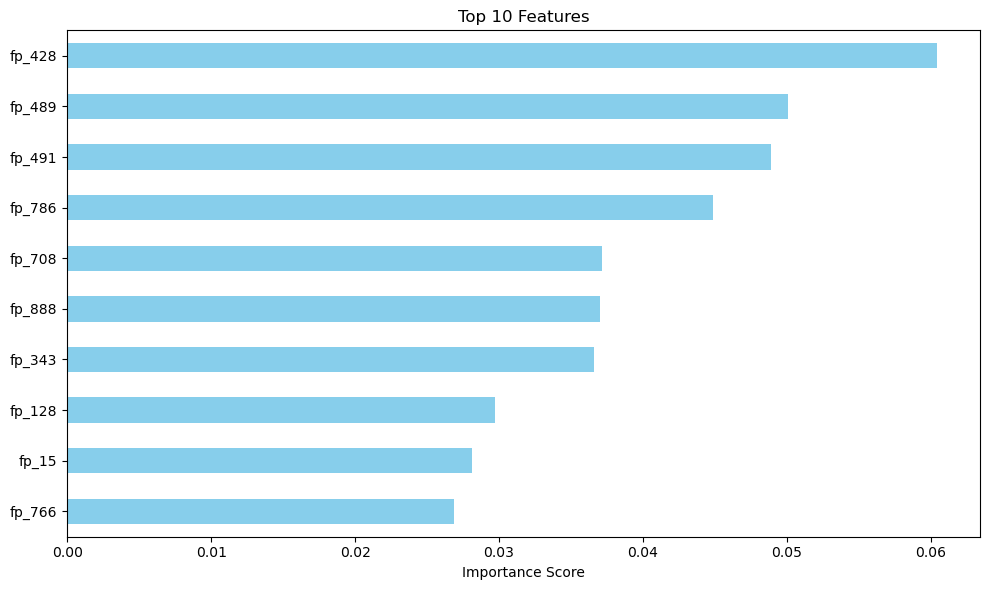

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score

# 1. Load the data generated in Step 6
df = pd.read_csv('/home/nikki/egfr_lowdata_scoring/results/real/features_real.csv')

# Define feature groups
physchem_cols = ['MW', 'LogP', 'HBD', 'HBA', 'TPSA']
fp_cols = [c for c in df.columns if c.startswith('fp_')]
docking_col = ['docking_score']

# 2. Prepare Feature Sets
# Set A: 2D Only (Fingerprints + PhysChem)
X_A = df[physchem_cols + fp_cols]

# Set B: 2D + Docking Score
X_B = df[physchem_cols + fp_cols + docking_col]

y = df['label']

# 3. Train/Test Split (80/20)
# Stratify=y ensures both sets have a similar balance of active/inactive
X_A_train, X_A_test, X_B_train, X_B_test, y_train, y_test = train_test_split(
    X_A, X_B, y, test_size=0.2, random_state=42, stratify=y
)

# 4. Define Evaluation Function
def evaluate_model(X_train, X_test, y_train, y_test, name):
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    preds = model.predict(X_test)
    probs = model.predict_proba(X_test)[:, 1]

    acc = accuracy_score(y_test, preds)
    try:
        auc = roc_auc_score(y_test, probs)
    except ValueError:
        auc = 0.5

    print(f"--- Model: {name} ---")
    print(f"Accuracy: {acc:.2f}")
    print(f"ROC-AUC:  {auc:.2f}\n")
    return model

# 5. Run Evaluations
model_a = evaluate_model(X_A_train, X_A_test, y_train, y_test, "A: 2D Descriptors Only")
model_b = evaluate_model(X_B_train, X_B_test, y_train, y_test, "B: 2D + Docking Score")

# 6. Feature Importance Visualization (The Sanity Check for Physics)
# We use Model B because it includes the docking_score feature
importances = model_b.feature_importances_
feature_names = physchem_cols + fp_cols + docking_col

# Combine into a Series for easy plotting
feat_importances = pd.Series(importances, index=feature_names)

# Plot the top 10 most influential features
plt.figure(figsize=(10,6))
feat_importances.nlargest(10).plot(kind='barh', color='skyblue')
plt.title("Top 10 Features")
plt.xlabel("Importance Score")
plt.gca().invert_yaxis() # Highest importance at the top
plt.tight_layout()
plt.show()